In [1]:
import json
import matplotlib.pyplot as plt

with open('train.json') as f:
    data = json.load(f)


## 1. NLI Label Distribution
- **Goal**: Understand how balanced the dataset is across the three NLI labels: Entailment, Contradiction, and NotMentioned.
- **Procedure**:
    - For each document, look at the choice field in the annotations and count how often each of the three labels appears.
    - Visualization: Bar plot showing the frequency of each NLI label (e.g., Entailment, Contradiction, NotMentioned).


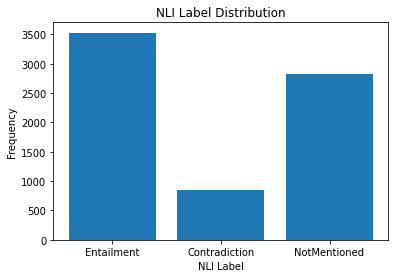

In [2]:
label_counts = {'Entailment': 0, 'Contradiction': 0, 'NotMentioned': 0}
for doc in data['documents']:
    for annotation_set in doc['annotation_sets']:
        for ann in annotation_set['annotations'].values():
            label_counts[ann['choice']] += 1

plt.bar(label_counts.keys(), label_counts.values())
plt.title("NLI Label Distribution")
plt.xlabel("NLI Label")
plt.ylabel("Frequency")
plt.show()

## 2. Document Length Distribution
- **Goal**: Measure the token length of the documents.
Since transformers like BERT have a maximum input length (typically 512 tokens), you need to check how many documents exceed this limit.
- **Procedure**:
For each document, count the total number of tokens based on the spans field (i.e., sum the differences between span start and end indices).
Visualization: Histogram showing the document length distribution (token count).


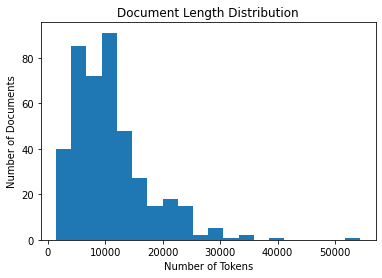

In [3]:
import numpy as np

document_lengths = []
for doc in data['documents']:
    length = sum(end - start for start, end in doc['spans'])
    document_lengths.append(length)

plt.hist(document_lengths, bins=20)
plt.title("Document Length Distribution")
plt.xlabel("Number of Tokens")
plt.ylabel("Number of Documents")
plt.show()


## 3. Span Length Distribution
- **Goal**: Analyze the distribution of evidence span lengths.
This is important because spans can vary in size, and some may be very short (a few words) or long (full paragraphs).
- **Procedure**:
For each document, count the length of the annotated evidence spans (from spans field inside the annotations).
Visualization: Histogram showing the length of evidence spans.


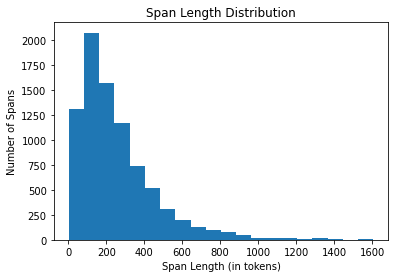

In [4]:
span_lengths = []
for doc in data['documents']:
    for annotation_set in doc['annotation_sets']:
        for ann in annotation_set['annotations'].values():
            for span_idx in ann['spans']:
                start, end = doc['spans'][span_idx]
                span_lengths.append(end - start)

plt.hist(span_lengths, bins=20)
plt.title("Span Length Distribution")
plt.xlabel("Span Length (in tokens)")
plt.ylabel("Number of Spans")
plt.show()


## 4. Number of Evidence Spans per Document
- **Goal**: Understand how many evidence spans are annotated in each document.
This helps analyze whether most documents contain a lot of evidence or just a few spans.
- **Procedure**:
For each document, count the number of spans present in the annotation_sets for the hypotheses that are classified as Entailment or Contradiction.
Visualization: Histogram or box plot showing the number of evidence spans per document.


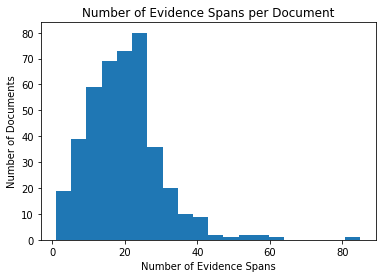

In [5]:
spans_per_document = []
for doc in data['documents']:
    count = 0
    for annotation_set in doc['annotation_sets']:
        for ann in annotation_set['annotations'].values():
            if ann['choice'] in ['Entailment', 'Contradiction']:
                count += len(ann['spans'])
    spans_per_document.append(count)

plt.hist(spans_per_document, bins=20)
plt.title("Number of Evidence Spans per Document")
plt.xlabel("Number of Evidence Spans")
plt.ylabel("Number of Documents")
plt.show()


## 5. Hypothesis-wise NLI Label Distribution

- **Goal**: Check if certain hypotheses (e.g., nda-1, nda-2) have an inherent bias towards specific labels (Entailment, Contradiction, NotMentioned).
- **Procedure**:
For each hypothesis (e.g., nda-1), count how often it is associated with each NLI label.
Visualization: A heatmap or grouped bar plot to show the label distribution for each hypothesis.

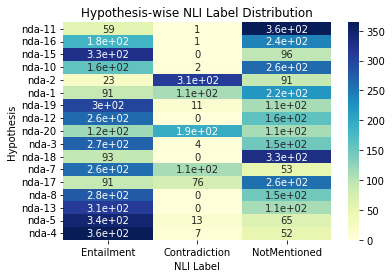

In [6]:
import seaborn as sns
import pandas as pd

# Initialize a dictionary to hold counts for each hypothesis
hypothesis_counts = {}
for doc in data['documents']:
    for annotation_set in doc['annotation_sets']:
        for hyp, ann in annotation_set['annotations'].items():
            if hyp not in hypothesis_counts:
                hypothesis_counts[hyp] = {'Entailment': 0, 'Contradiction': 0, 'NotMentioned': 0}
            hypothesis_counts[hyp][ann['choice']] += 1

df = pd.DataFrame(hypothesis_counts).T

sns.heatmap(df, annot=True, cmap="YlGnBu")
plt.title("Hypothesis-wise NLI Label Distribution")
plt.xlabel("NLI Label")
plt.ylabel("Hypothesis")
plt.show()


## 6. Overlapping Evidence Spans
- **Goal**: Check how often evidence spans overlap across multiple hypotheses in the same document.
This is important because overlapping spans may complicate the model's learning process.
- **Procedure**:
For each document, check whether the spans in the annotations overlap.
Visualization: You can summarize the proportion of overlapping spans across the dataset.

In [7]:
overlapping_spans = 0
total_spans = 0

for doc in data['documents']:
    spans = []
    for annotation_set in doc['annotation_sets']:
        for ann in annotation_set['annotations'].values():
            spans += [doc['spans'][idx] for idx in ann['spans']]
    
    spans.sort(key=lambda x: x[0])

    for i in range(1, len(spans)):
        if spans[i][0] < spans[i-1][1]: 
            overlapping_spans += 1
    total_spans += len(spans)

overlap_ratio = overlapping_spans / total_spans
print(f"Proportion of overlapping spans: {overlap_ratio:.2f}")


Proportion of overlapping spans: 0.26


## 7. Span Location within Documents
- **Goal**: Identify where evidence spans are typically located within documents.
Do spans cluster towards the beginning, middle, or end of the document?
This helps you understand if the model needs to focus more on certain sections of the document.
- **Procedure**:
For each document, calculate the relative position of each span as a percentage of the document length.
Visualization: Violin plot or scatter plot showing the distribution of span locations within documents.


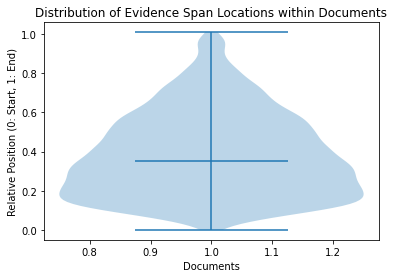

In [8]:
relative_positions = []

for doc in data['documents']:
    doc_length = sum(end - start for start, end in doc['spans'])
    for annotation_set in doc['annotation_sets']:
        for ann in annotation_set['annotations'].values():
            for span_idx in ann['spans']:
                start, end = doc['spans'][span_idx]
                relative_position = (start + end) / 2 / doc_length  # Midpoint of span relative to doc length
                relative_positions.append(relative_position)

plt.violinplot(relative_positions, showmedians=True)
plt.title("Distribution of Evidence Span Locations within Documents")
plt.xlabel("Documents")
plt.ylabel("Relative Position (0: Start, 1: End)")
plt.show()


## 8. Span Density by Document
- **Goal**: Measure the "density" of evidence spans in each document.
How concentrated are evidence spans? Are there documents with lots of dense spans, or are they spaced out?
- **Procedure**:
For each document, calculate the total number of spans and divide by the document length (in tokens).
Visualization: Histogram showing span density across documents.


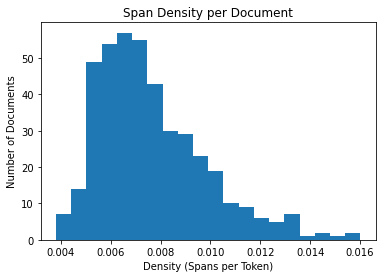

In [9]:
span_density = []

for doc in data['documents']:
    doc_length = sum(end - start for start, end in doc['spans'])
    num_spans = len(doc['spans'])
    density = num_spans / doc_length if doc_length > 0 else 0
    span_density.append(density)

plt.hist(span_density, bins=20)
plt.title("Span Density per Document")
plt.xlabel("Density (Spans per Token)")
plt.ylabel("Number of Documents")
plt.show()


## 9. Hypothesis-Specific Span Length Analysis
- **Goal**: Investigate the span length for different hypotheses (e.g., nda-1, nda-16) to determine if certain hypotheses are linked with shorter or longer evidence spans.
- **Procedure**:
For each hypothesis, measure the lengths of its associated evidence spans and compare the distributions across different hypotheses.
Visualization: Box plot showing span length distributions for different hypotheses

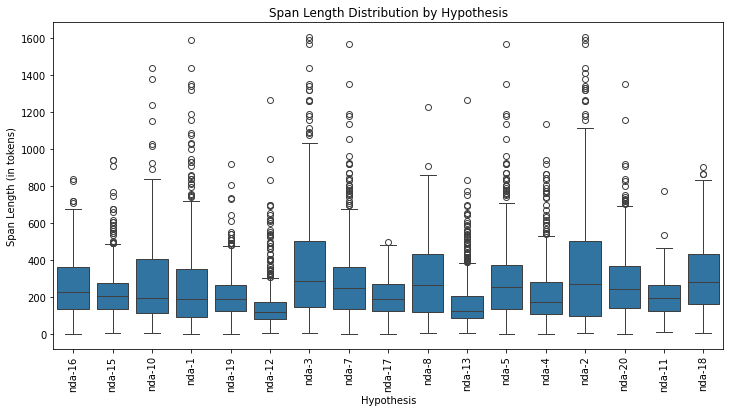

In [10]:
import seaborn as sns

span_lengths_by_hypothesis = {}
for doc in data['documents']:
    for annotation_set in doc['annotation_sets']:
        for hyp, ann in annotation_set['annotations'].items():
            for span_idx in ann['spans']:
                start, end = doc['spans'][span_idx]
                if hyp not in span_lengths_by_hypothesis:
                    span_lengths_by_hypothesis[hyp] = []
                span_lengths_by_hypothesis[hyp].append(end - start)

data_for_plot = [(hyp, length) for hyp, lengths in span_lengths_by_hypothesis.items() for length in lengths]
df = pd.DataFrame(data_for_plot, columns=["Hypothesis", "Span Length"])

plt.figure(figsize=(12, 6))
sns.boxplot(x="Hypothesis", y="Span Length", data=df)
plt.title("Span Length Distribution by Hypothesis")
plt.xlabel("Hypothesis")
plt.ylabel("Span Length (in tokens)")
plt.xticks(rotation=90)
plt.show()


## 10. Co-occurrence of NLI Labels
- **Goal**: Analyze the co-occurrence of different NLI labels within the same document.
Do documents typically contain multiple hypotheses with conflicting labels (e.g., one hypothesis being Entailment and another Contradiction)?
- **Procedure**:
For each document, check the number of hypotheses with each NLI label and analyze co-occurrences.
Visualization: Heatmap or Venn diagram showing the co-occurrence of Entailment, Contradiction, and NotMentioned labels in the same document.



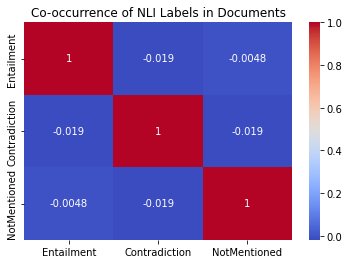

In [12]:
import seaborn as sns

cooccurrences = {'Entailment': [], 'Contradiction': [], 'NotMentioned': []}
for doc in data['documents']:
    label_set = set()
    for annotation_set in doc['annotation_sets']:
        for ann in annotation_set['annotations'].values():
            label_set.add(ann['choice'])
    
    for label in cooccurrences.keys():
        cooccurrences[label].append(1 if label in label_set else 0)

df = pd.DataFrame(cooccurrences)

sns.heatmap(df.corr(), annot=True, cmap="coolwarm")
plt.title("Co-occurrence of NLI Labels in Documents")
plt.show()
